# Notebook to format data from "Movement Sensor Dataset for Dog Behavior Classification", Vehkaoja et al (2017).

[Data is here](https://data.mendeley.com/datasets/vxhx934tbn/1) 

[Related paper is here](https://www.sciencedirect.com/science/article/pii/S0168159121001805#:~:text=Two%20sensor%20devices%20were%20attached,one%20on%20the%20neck%20collar.&text=The%20results%20were%20promising%3B%20the,yielded%2075%20%25%20accuracy%20at%20best.)

## Setup

In [1]:
# Outputs:
# formatted dataset directory
# dataset_metadata (yaml), includes
## sample_rate
## dataset_label_names (list)
## dataset_feature_names (list)
## clip_ids (list)
# clip_data (directory), includes
## data_files (multiple files)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import pandas as pd
import h5py
from matplotlib import pyplot as plt
import glob
import yaml
import tqdm
import scipy.signal as signal

In [4]:
# Specify data filepaths

raw_data_dir = '/home/jupyter/behavior_data_local/data/raw/vehkaoja_dogs'
formatted_data_dir = '/home/jupyter/behavior_data_local/data/formatted/vehkaoja_dogs'

if not os.path.exists(formatted_data_dir):
    os.makedirs(formatted_data_dir)
    
data_fp = os.path.join(raw_data_dir, 'DogMoveData.csv')

clip_data_dir = os.path.join(formatted_data_dir, 'clip_data')
if not os.path.exists(clip_data_dir):
    os.makedirs(clip_data_dir)

In [5]:
# Set up clip ids and metadata

# Dataset metadata
dataset_metadata = {}
sr = 100
dataset_metadata['sr'] = sr ## from dataset documentation
dataset_metadata['dataset_name'] = 'vehkaoja_dogs'

In [6]:
data_full = pd.read_csv(data_fp)

In [7]:
def create_clip_id(row):
    return 'individual_' + str(row['DogID']) + '_test_' + str(row['TestNum'])

data_full['clip_id'] = data_full.apply(create_clip_id, axis = 1)

In [8]:
# Get a list of the individual ids

individual_ids = sorted(set(data_full['DogID']))
dataset_metadata['individual_ids'] = individual_ids

In [9]:
# Clip ids
clip_ids = sorted(set(data_full['clip_id']))  
dataset_metadata['clip_ids'] = clip_ids

In [10]:
# Set up data splits by individual

test_proportion = .25
val_proportion = .10
num_individuals = len(individual_ids)

test_num_individuals = int(test_proportion * num_individuals)
val_num_individuals = int(val_proportion * num_individuals)

rng = np.random.default_rng(607)
test_individuals = list(rng.choice(individual_ids, size = test_num_individuals, replace = False))
test_individuals.sort()

dev_individuals = individual_ids.copy()
for i in test_individuals:
    dev_individuals.remove(i)
    
val_individuals = list(rng.choice(dev_individuals, size = val_num_individuals, replace = False))
val_individuals.sort()
    
train_individuals = dev_individuals.copy()
for i in val_individuals:
    train_individuals.remove(i)
    
print(train_individuals)
print(val_individuals)
print(dev_individuals)
print(test_individuals)

[18, 19, 20, 21, 22, 23, 26, 27, 28, 30, 33, 34, 36, 39, 43, 44, 45, 46, 47, 51, 53, 54, 56, 57, 58, 63, 68, 70, 72, 73]
[25, 59, 61, 66]
[18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 33, 34, 36, 39, 43, 44, 45, 46, 47, 51, 53, 54, 56, 57, 58, 59, 61, 63, 66, 68, 70, 72, 73]
[16, 29, 41, 48, 49, 52, 55, 60, 65, 67, 74]


In [11]:
## Integer codes for individuals

clip_id_to_individual_id = {clip_id : int(clip_id.split('_')[1]) for clip_id in clip_ids}
dataset_metadata['clip_id_to_individual_id'] = clip_id_to_individual_id

In [12]:
train_clip_ids = []
test_clip_ids = []
val_clip_ids = []
dev_clip_ids = []
for clip_id in clip_ids:
    individual = clip_id_to_individual_id[clip_id]
    if individual in train_individuals:
        train_clip_ids.append(clip_id)
        dev_clip_ids.append(clip_id)
    elif individual in val_individuals:
        val_clip_ids.append(clip_id)
        dev_clip_ids.append(clip_id)
    elif individual in test_individuals:
        test_clip_ids.append(clip_id)
train_clip_ids.sort()
val_clip_ids.sort()
dev_clip_ids.sort()
test_clip_ids.sort()
    
dataset_metadata['train_clip_ids'] = train_clip_ids
dataset_metadata['test_clip_ids'] = test_clip_ids
dataset_metadata['val_clip_ids'] = val_clip_ids
dataset_metadata['dev_clip_ids'] = dev_clip_ids

## Create dataset-level metadata

Each frame can be annotated with up to three behaviors simultaneously. We want to pare it down to a typical multi-class classification problem. We will eliminate some of the labels, since they typically occur coincidentally with other behaviors. After this, if frames have more than one label we call them `unknown`

In [13]:
# Get the names of the observed labels

observed_labels = list(set(data_full['Behavior_1']).union(data_full['Behavior_3']).union(data_full['Behavior_3']))
observed_labels.sort()

print(observed_labels)

['<undefined>', 'Bowing', 'Carrying object', 'Drinking', 'Eating', 'Extra_Synchronization', 'Galloping', 'Jumping', 'Lying chest', 'Pacing', 'Panting', 'Playing', 'Shaking', 'Sitting', 'Sniffing', 'Standing', 'Synchronization', 'Trotting', 'Tugging', 'Walking']


In [14]:
if False:
    coincident_behaviors = {}
    print(len(data_full))
    for i, row in tqdm.tqdm(data_full.iterrows()):
        row_behaviors = set(row[['Behavior_1', 'Behavior_2', 'Behavior_3']])
        row_behaviors.discard('<undefined>')
        row_behaviors = list(row_behaviors)
        row_behaviors.sort()
        row_behaviors = tuple(row_behaviors)
        if row_behaviors not in coincident_behaviors:
            coincident_behaviors[row_behaviors] = 0
        coincident_behaviors[row_behaviors] += 1

    {k: v for k, v in sorted(coincident_behaviors.items(), key=lambda item: item[1])}

In [15]:
#output of the previous cell

'''
{('Playing', 'Tugging', 'Walking'): 3,
 ('Bowing',): 4,
 ('Panting', 'Playing', 'Standing'): 16,
 ('Shaking', 'Synchronization'): 35,
 ('Carrying object', 'Playing'): 44,
 ('Lying chest', 'Playing'): 58,
 ('Playing', 'Standing'): 60,
 ('Carrying object', 'Shaking'): 91,
 ('Eating', 'Panting', 'Sitting'): 95,
 ('Playing', 'Walking'): 119,
 ('Lying chest', 'Panting', 'Playing'): 174,
 ('Carrying object', 'Playing', 'Walking'): 182,
 ('Eating', 'Galloping'): 195,
 ('Eating',): 219,
 ('Carrying object', 'Playing', 'Standing'): 247,
 ('Bowing', 'Eating'): 271,
 ('Extra_Synchronization',): 287,
 ('Playing', 'Shaking'): 303,
 ('Pacing', 'Playing'): 382,
 ('Carrying object', 'Playing', 'Shaking'): 384,
 ('Eating', 'Pacing'): 449,
 ('Eating', 'Panting', 'Standing'): 477,
 ('Carrying object', 'Lying chest', 'Playing'): 687,
 ('Carrying object', 'Pacing', 'Playing'): 1002,
 ('Carrying object', 'Standing'): 1075,
 ('Tugging',): 1134,
 ('Bowing', 'Carrying object', 'Playing'): 1265,
 ('Carrying object', 'Lying chest'): 1832,
 ('Panting',): 2331,
 ('Carrying object', 'Trotting'): 2780,
 ('Carrying object', 'Jumping', 'Playing'): 3653,
 ('Galloping',): 3668,
 ('Playing', 'Trotting'): 6430,
 ('Carrying object', 'Walking'): 6861,
 ('Eating', 'Trotting'): 10752,
 ('Synchronization',): 16720,
 ('Jumping', 'Playing', 'Tugging'): 18199,
 ('Jumping', 'Playing'): 20224,
 ('Eating', 'Walking'): 25552,
 ('Carrying object', 'Playing', 'Trotting'): 36445,
 ('Shaking',): 41366,
 ('Drinking',): 64721,
 ('Pacing',): 76766,
 ('Eating', 'Sitting'): 77448,
 ('Eating', 'Lying chest'): 81368,
 ('Galloping', 'Playing'): 81752,
 ('Carrying object', 'Galloping', 'Playing'): 89311,
 ('Eating', 'Standing'): 115980,
 ('Playing', 'Tugging'): 277766,
 ('Standing',): 370930,
 ('Sitting',): 389467,
 ('Playing',): 398320,
 ('Lying chest',): 463266,
 ('Panting', 'Standing'): 538925,
 ('Lying chest', 'Panting'): 582517,
 ('Panting', 'Sitting'): 653106,
 ('Trotting',): 717472,
 ('Walking',): 750318,
 ('Sniffing',): 1026178,
 (): 3649386}
 '''

"\n{('Playing', 'Tugging', 'Walking'): 3,\n ('Bowing',): 4,\n ('Panting', 'Playing', 'Standing'): 16,\n ('Shaking', 'Synchronization'): 35,\n ('Carrying object', 'Playing'): 44,\n ('Lying chest', 'Playing'): 58,\n ('Playing', 'Standing'): 60,\n ('Carrying object', 'Shaking'): 91,\n ('Eating', 'Panting', 'Sitting'): 95,\n ('Playing', 'Walking'): 119,\n ('Lying chest', 'Panting', 'Playing'): 174,\n ('Carrying object', 'Playing', 'Walking'): 182,\n ('Eating', 'Galloping'): 195,\n ('Eating',): 219,\n ('Carrying object', 'Playing', 'Standing'): 247,\n ('Bowing', 'Eating'): 271,\n ('Extra_Synchronization',): 287,\n ('Playing', 'Shaking'): 303,\n ('Pacing', 'Playing'): 382,\n ('Carrying object', 'Playing', 'Shaking'): 384,\n ('Eating', 'Pacing'): 449,\n ('Eating', 'Panting', 'Standing'): 477,\n ('Carrying object', 'Lying chest', 'Playing'): 687,\n ('Carrying object', 'Pacing', 'Playing'): 1002,\n ('Carrying object', 'Standing'): 1075,\n ('Tugging',): 1134,\n ('Bowing', 'Carrying object', 'Pla

Now we define the mapping from `observed_labels` to the `beh_labels` we will use

In [16]:
# We re-code each of the three behaviors according to the following:
# This is following "Dog behaviour classification with movement sensors placed on the harness and the collar"
# Except we include panting, because it is so strongly represented
# We also include shaking, because the signal is so strong

observed_labels_to_beh_label_first_pass = {'<undefined>' : 'unknown',
                                           'Bowing' : 'unknown', 
                                           'Carrying object' : 'unknown', 
                                           'Drinking' : 'unknown', 
                                           'Eating' : 'unknown',
                                           'Extra_Synchronization' : 'unknown',
                                           'Galloping' : 'galloping',
                                           'Jumping' : 'unknown', 
                                           'Lying chest' : 'lying_chest',
                                           'Pacing' : 'unknown',
                                           'Panting' : 'panting', # will get incorporated in second pass
                                           'Playing' : 'unknown',
                                           'Shaking' : 'shaking',
                                           'Sitting' : 'sitting',
                                           'Sniffing' : 'sniffing',
                                           'Standing' : 'standing',
                                           'Synchronization' : 'unknown',
                                           'Trotting' : 'trotting',
                                           'Tugging' : 'unknown', 
                                           'Walking' : 'walking'}

# add the re-coded columns

data_full['B1_beh'] = data_full['Behavior_1'].map(observed_labels_to_beh_label_first_pass)
data_full['B2_beh'] = data_full['Behavior_2'].map(observed_labels_to_beh_label_first_pass)
data_full['B3_beh'] = data_full['Behavior_3'].map(observed_labels_to_beh_label_first_pass)

In [17]:
# Use these three columns to form single labels.

def beh_label_first_pass_to_second_pass(row):
    B1 = row['B1_beh']
    B2 = row['B2_beh']
    B3 = row['B3_beh']
    all_beh = set([B1, B2, B3])
    all_beh.discard('unknown')
    if len(all_beh) == 0:
        return 'unknown'
    elif len(all_beh) > 2:
        return 'unknown'
    elif 'panting' in all_beh:
        if 'standing' in all_beh:
            return 'panting_standing'
        elif 'sitting' in all_beh:
            return 'panting_sitting'
        elif 'lying_chest' in all_beh:
            return 'panting_lying_chest'
        else:
            return 'unknown'
    elif len(all_beh) == 1:
        return all_beh.pop()
    else:
        return 'unknown'

In [18]:
# Convert to final beh_labels

data_full['beh_label'] = data_full.apply(beh_label_first_pass_to_second_pass, axis = 1)

In [19]:
## Integer codes for specific behaviors

# list of behaviors (from Jeantet et al 2020)
beh_names = set(data_full['beh_label'])
beh_names.discard('unknown')
beh_names = sorted(beh_names)
beh_names.insert(0, 'unknown')

dataset_metadata['label_names'] = beh_names

beh_str_to_int = {name : i for i, name in enumerate(beh_names)}
beh_int_to_str = {i : name for i, name in enumerate(beh_names)}

In [20]:
# What are the observed labels?

data_full['beh_label'].value_counts()

unknown                4533143
sniffing               1026178
walking                 783035
trotting                773879
panting_sitting         653201
panting_lying_chest     582691
lying_chest             547211
panting_standing        539418
standing                488292
sitting                 466915
galloping               174926
shaking                  42179
Name: beh_label, dtype: int64

In [21]:
## What are the annotation names in the data originally?

data_full.columns

Index(['DogID', 'TestNum', 't_sec', 'ABack_x', 'ABack_y', 'ABack_z', 'ANeck_x',
       'ANeck_y', 'ANeck_z', 'GBack_x', 'GBack_y', 'GBack_z', 'GNeck_x',
       'GNeck_y', 'GNeck_z', 'Task', 'Behavior_1', 'Behavior_2', 'Behavior_3',
       'PointEvent', 'clip_id', 'B1_beh', 'B2_beh', 'B3_beh', 'beh_label'],
      dtype='object')

In [22]:
## clip_data column names

clip_column_names = ['AccX_Back', 'AccY_Back', 'AccZ_Back', 'AccX_Neck',
       'AccY_Neck', 'AccZ_Neck', 'StaticAccX_Back', 'StaticAccY_Back', 'StaticAccZ_Back', 'StaticAccX_Neck',
       'StaticAccY_Neck', 'StaticAccZ_Neck', 'GyrX_Back', 'GyrY_Back', 'GyrZ_Back', 'GyrX_Neck',
       'GyrY_Neck', 'GyrZ_Neck', 'individual_id', 'label']
dataset_metadata['clip_column_names'] = clip_column_names

In [23]:
## Save off dataset level metadata

dataset_metadata_fp = os.path.join(formatted_data_dir, 'dataset_metadata.yaml')

with open(dataset_metadata_fp, 'w') as file:
    yaml.dump(dataset_metadata, file)

## Format Clip Data

In [24]:

def smooth(series, smoothing_cutoff_freq):
    # smooth
    sos = signal.butter(10, smoothing_cutoff_freq, 'low', fs = sr, output = 'sos')
    series = signal.sosfilt(sos, series)
    return series

def extract_static(series, low_cutoff_freq):
    # extract static component
    sos = signal.butter(10, low_cutoff_freq, 'low', fs=sr, output='sos')
    low_passed_series = signal.sosfilt(sos, series)
    remaining_series = series - low_passed_series
    return low_passed_series, remaining_series

In [25]:
# For each clip, create and save the data in the correct format

total_dur_samples = 0

for clip_id in tqdm.tqdm(clip_ids):
    # subselect features
    clip_df = data_full[data_full['clip_id'] == clip_id]
    clip_dur_samples = len(clip_df)
    
    total_dur_samples += clip_dur_samples
    
    # 'AccX_Back', 'AccY_Back', 'AccZ_Back', 'AccX_Neck',
    # 'AccY_Neck', 'AccZ_Neck', 'StaticAccX_Back', 'StaticAccY_Back', 'StaticAccZ_Back', 'StaticAccX_Neck',
    # 'StaticAccY_Neck', 'StaticAccZ_Neck','GyrX_Back', 'GyrY_Back', 'GyrZ_Back', 'GyrX_Neck',
    # 'GyrY_Neck', 'GyrZ_Neck', 'individual_id', 'label']
    
    # smooth
    per_frame_AccX_Back = smooth(np.array(clip_df['ABack_x']), 20.)
    per_frame_AccY_Back = smooth(np.array(clip_df['ABack_y']), 20.)
    per_frame_AccZ_Back = smooth(np.array(clip_df['ABack_z']), 20.)
    
    per_frame_AccX_Neck = smooth(np.array(clip_df['ANeck_x']), 20.)
    per_frame_AccY_Neck = smooth(np.array(clip_df['ANeck_y']), 20.)
    per_frame_AccZ_Neck = smooth(np.array(clip_df['ANeck_z']), 20.)
    
    per_frame_GyrX_Back = smooth(np.array(clip_df['GBack_x']), 20.)
    per_frame_GyrY_Back = smooth(np.array(clip_df['GBack_y']), 20.)
    per_frame_GyrZ_Back = smooth(np.array(clip_df['GBack_z']), 20.)
    
    per_frame_GyrX_Neck = smooth(np.array(clip_df['GNeck_x']), 20.)
    per_frame_GyrY_Neck = smooth(np.array(clip_df['GNeck_y']), 20.)
    per_frame_GyrZ_Neck = smooth(np.array(clip_df['GNeck_z']), 20.)
    
    # collect static acc components
    per_frame_StaticAccX_Back, per_frame_AccX_Back = extract_static(per_frame_AccX_Back, 0.3)
    per_frame_StaticAccY_Back, per_frame_AccY_Back = extract_static(per_frame_AccY_Back, 0.3)
    per_frame_StaticAccZ_Back, per_frame_AccZ_Back = extract_static(per_frame_AccZ_Back, 0.3)
    
    per_frame_StaticAccX_Neck, per_frame_AccX_Neck = extract_static(per_frame_AccX_Neck, 0.3)
    per_frame_StaticAccY_Neck, per_frame_AccY_Neck = extract_static(per_frame_AccY_Neck, 0.3)
    per_frame_StaticAccZ_Neck, per_frame_AccZ_Neck = extract_static(per_frame_AccZ_Neck, 0.3)
    
    # collect and reformat
    per_frame_AccX_Back = np.expand_dims(per_frame_AccX_Back, axis = -1)
    per_frame_AccY_Back = np.expand_dims(per_frame_AccY_Back, axis = -1)
    per_frame_AccZ_Back = np.expand_dims(per_frame_AccZ_Back, axis = -1)
    
    per_frame_AccX_Neck = np.expand_dims(per_frame_AccX_Neck, axis = -1)
    per_frame_AccY_Neck = np.expand_dims(per_frame_AccY_Neck, axis = -1)
    per_frame_AccZ_Neck = np.expand_dims(per_frame_AccZ_Neck, axis = -1)
    
    per_frame_StaticAccX_Back = np.expand_dims(per_frame_StaticAccX_Back, axis = -1)
    per_frame_StaticAccY_Back = np.expand_dims(per_frame_StaticAccY_Back, axis = -1)
    per_frame_StaticAccZ_Back = np.expand_dims(per_frame_StaticAccZ_Back, axis = -1)
    
    per_frame_StaticAccX_Neck = np.expand_dims(per_frame_StaticAccX_Neck, axis = -1)
    per_frame_StaticAccY_Neck = np.expand_dims(per_frame_StaticAccY_Neck, axis = -1)
    per_frame_StaticAccZ_Neck = np.expand_dims(per_frame_StaticAccZ_Neck, axis = -1)
    
    per_frame_GyrX_Back = np.expand_dims(per_frame_GyrX_Back, axis = -1)
    per_frame_GyrY_Back = np.expand_dims(per_frame_GyrY_Back, axis = -1)
    per_frame_GyrZ_Back = np.expand_dims(per_frame_GyrZ_Back, axis = -1)
    
    per_frame_GyrX_Neck = np.expand_dims(per_frame_GyrX_Neck, axis = -1)
    per_frame_GyrY_Neck = np.expand_dims(per_frame_GyrY_Neck, axis = -1)
    per_frame_GyrZ_Neck = np.expand_dims(per_frame_GyrZ_Neck, axis = -1)
    
    
    
    per_frame_annotations = np.expand_dims(np.array(clip_df['beh_label'].map(lambda x: beh_str_to_int[x])), axis = -1)
    
    individual_id = clip_id_to_individual_id[clip_id]
    per_frame_individual_id = np.full_like(per_frame_annotations, individual_id)
    
    
    clip_data = np.concatenate([per_frame_AccX_Back,
                                per_frame_AccY_Back,
                                per_frame_AccZ_Back,
                                per_frame_AccX_Neck,
                                per_frame_AccY_Neck,
                                per_frame_AccZ_Neck,
                                per_frame_StaticAccX_Back,
                                per_frame_StaticAccY_Back,
                                per_frame_StaticAccZ_Back,
                                per_frame_StaticAccX_Neck,
                                per_frame_StaticAccY_Neck,
                                per_frame_StaticAccZ_Neck,
                                per_frame_GyrX_Back,
                                per_frame_GyrY_Back,
                                per_frame_GyrZ_Back,
                                per_frame_GyrX_Neck,
                                per_frame_GyrY_Neck,
                                per_frame_GyrZ_Neck,
                                per_frame_individual_id, 
                                per_frame_annotations], axis = 1)
    
    clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
    np.savetxt(clip_data_fp, clip_data, delimiter=",")

100%|██████████| 62/62 [04:41<00:00,  4.54s/it]


In [26]:
total_dur_sec = total_dur_samples / sr
total_dur_hours = total_dur_sec / 3600
print("total duration is %f seconds, i.e. %f hours" % (total_dur_sec, total_dur_hours))

total duration is 106110.680000 seconds, i.e. 294.751889 hours


## Check it all looks ok

In [35]:
clip_id = clip_ids[4]
clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
data = np.genfromtxt(clip_data_fp, delimiter = ',')

In [36]:
np.shape(data)

(185904, 20)

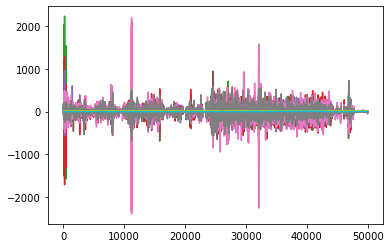

In [37]:
for i in range(np.shape(data)[1]):
    plt.plot(data[:50000, i])

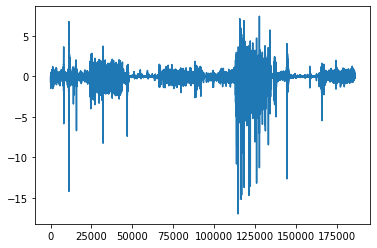

In [38]:
plt.plot(data[:, 5])

## Plot Dataset Summary

In [31]:
# Count class representation

beh_names = dataset_metadata['label_names']
train_label_count = {name : 0 for name in beh_names}
val_label_count = {name : 0 for name in beh_names}
dev_label_count = {name : 0 for name in beh_names}
test_label_count = {name : 0 for name in beh_names}

for clip_id in clip_ids:
    clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
    data = pd.read_csv(clip_data_fp, delimiter = ',', header = None)
    counts = data[data.keys()[-1]].astype(int).value_counts()
    for key in counts.keys():
        name = beh_names[key]
        if clip_id in dataset_metadata['train_clip_ids']:
            train_label_count[name] += counts[key]
            dev_label_count[name] += counts[key]
        elif clip_id in dataset_metadata['val_clip_ids']:
            val_label_count[name] += counts[key]
            dev_label_count[name] += counts[key]
        elif clip_id in dataset_metadata['test_clip_ids']:
            test_label_count[name] += counts[key]

train_label_perc = {name : 0 for name in beh_names}
val_label_perc = {name : 0 for name in beh_names}
dev_label_perc = {name : 0 for name in beh_names}
test_label_perc = {name : 0 for name in beh_names}

for name in beh_names[1:]:
    train_label_perc[name] = train_label_count[name] / sum([train_label_count[j] for j in beh_names[1:]])
    val_label_perc[name] = val_label_count[name] / sum([val_label_count[j] for j in beh_names[1:]])
    dev_label_perc[name] = dev_label_count[name] / sum([dev_label_count[j] for j in beh_names[1:]])
    test_label_perc[name] = test_label_count[name] / sum([test_label_count[j] for j in beh_names[1:]])

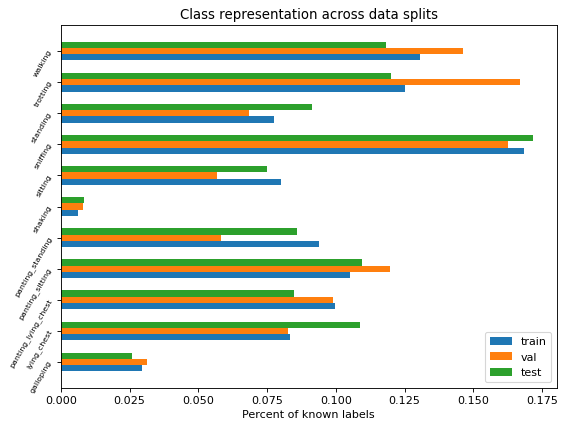

In [32]:
# Plot class representation

keys = np.arange(len(beh_names))[1:]
offset = 0.2
width = 0.2
plt.figure(figsize=(8, 6), dpi=80)

plt.barh(keys - offset, [train_label_perc[beh_names[key]] for key in keys], height=width, align='center', label = 'train')
plt.barh(keys, [val_label_perc[beh_names[key]] for key in keys], height=width, align='center', label = 'val')
plt.barh(keys + offset, [test_label_perc[beh_names[key]] for key in keys], height=width, align='center', label = 'test')
plt.title("Class representation across data splits")
plt.yticks(keys, beh_names[1:], fontsize = 7, rotation = 60)
plt.xlabel('Percent of known labels')
plt.legend()
target_fp = os.path.join(formatted_data_dir, 'class_rep.png')

plt.savefig(target_fp)
plt.show()

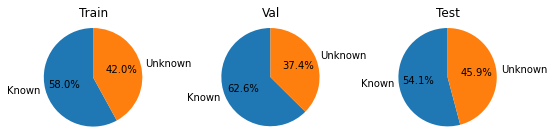

In [33]:
# Pie chart, of known vs unknown samples 

labels = 'Known', 'Unknown'
train_sizes = [sum([train_label_count[j] for j in beh_names[1:]]), train_label_count['unknown']]
val_sizes = [sum([val_label_count[j] for j in beh_names[1:]]), val_label_count['unknown']]
test_sizes = [sum([test_label_count[j] for j in beh_names[1:]]), test_label_count['unknown']]

fig, ax = plt.subplots(1,3, figsize = (9,2))
plt.title("blah")

ax[0].pie(train_sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[0].set_title('Train')

ax[1].pie(val_sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[1].set_title('Val')

ax[2].pie(test_sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax[2].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[2].set_title('Test')

target_fp = os.path.join(formatted_data_dir, 'perc_known.png')

plt.savefig(target_fp)

plt.show()
